In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
phsyical_devices = tf.config.experimental.list_physical_devices("GPU")# True/False
print("Num GPUs available : " , len(phsyical_devices))
tf.config.experimental.set_memory_growth(phsyical_devices[0], True)
print(tf.__version__)

Num GPUs available :  1
2.5.0


In [3]:
def plot_confusion_matrix(cm, classes,normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else :
        print("Confusion matrix without normalization")

    print(cm)

    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [4]:
premodel = tf.keras.applications.vgg16.VGG16()

In [5]:
premodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
output = premodel.layers[-5].output
output = Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(output)
output = Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")(output)
output = MaxPool2D()(output)
output = Flatten()(output)
output = Dense(units=4, activation="softmax")(output)

In [7]:
model = Model(inputs=premodel.input, outputs=output)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
for layer in model.layers[:-5]:
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.005), loss="categorical_crossentropy", metrics=["accuracy"])

In [11]:
train_path = "data/train"
valid_path = "data/valid"
test_path = "data/test"

In [14]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=16)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=16)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=16, shuffle=False)
                    

Found 3957 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [15]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=6, verbose=2, workers=16)

Epoch 1/10
248/248 - 131s - loss: 2.0196 - accuracy: 0.8370 - val_loss: 0.1151 - val_accuracy: 0.9725
Epoch 2/10
248/248 - 121s - loss: 0.2581 - accuracy: 0.9570 - val_loss: 0.2454 - val_accuracy: 0.9250
Epoch 3/10
248/248 - 109s - loss: 0.3104 - accuracy: 0.9606 - val_loss: 0.2402 - val_accuracy: 0.9600
Epoch 4/10
248/248 - 115s - loss: 0.1015 - accuracy: 0.9826 - val_loss: 0.2709 - val_accuracy: 0.9475
Epoch 5/10
248/248 - 109s - loss: 0.0172 - accuracy: 0.9947 - val_loss: 0.1433 - val_accuracy: 0.9675
Epoch 6/10
248/248 - 104s - loss: 0.0176 - accuracy: 0.9967 - val_loss: 0.1840 - val_accuracy: 0.9600
Epoch 7/10


KeyboardInterrupt: 

In [52]:
# model.save("my_rabbit_classifier_vgg16.h5")

In [16]:
test_labels = test_batches.classes

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

In [18]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [19]:
test_batches.class_indices

{'andromeda': 0, 'merlin': 1, 'morgana': 2, 'perseus': 3}

Confusion matrix without normalization
[[30  0  0  0]
 [ 2 18  4  6]
 [ 0  0 30  0]
 [ 0  0  0 30]]


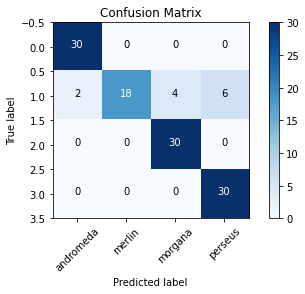

In [20]:
cm_plot_labels = ["andromeda","merlin","morgana","perseus"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")